# Homework 1 - Exercise 1 

In [28]:
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import itertools

Create the graph 

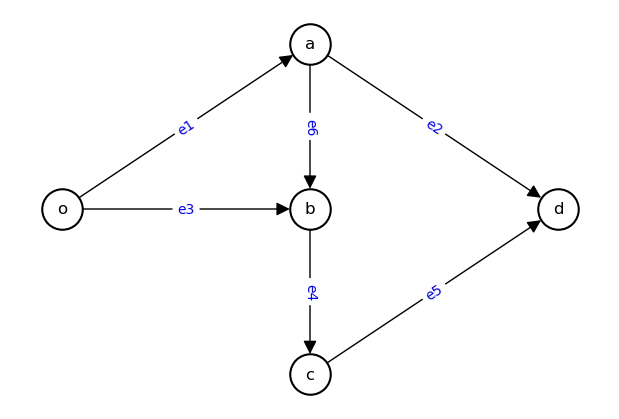

In [29]:
#Create an empty Directed Graph 
G = nx.DiGraph()

# Add nodes and edges to the graph 
G.add_nodes_from(["a", "b", "c", "o", "d"])
G.add_edges_from([("o", "b"), ("o", "a"), ("a", "b"), ("b", "c"), ("a", "d"), ("c", "d")])

# Define capacities for each edge
c1 = c2 = c3 = c4 = 3
c5 = 2
c6 = 1

# Set edge labels and capacities
nx.set_edge_attributes(G, {
    ("o", "a"): "e1",
    ("a", "d"): "e2",
    ("o", "b"): "e3",
    ("b", "c"): "e4",
    ("c", "d"): "e5",
    ("a", "b"): "e6"
}, "label")

nx.set_edge_attributes(G, {
    ("o", "a"): c1,  # e1
    ("a", "d"): c2,  # e2
    ("o", "b"): c3,  # e3
    ("b", "c"): c4,  # e4
    ("c", "d"): c5,  # e5
    ("a", "b"): c6   # e6
}, "capacity")

# Manual layout to match the given one
pos = {
    "o": (0.0, 0.0),
    "a": (1.2, 0.8),
    "b": (1.2, 0.0),
    "c": (1.2, -0.8),
    "d": (2.4, 0.0)
}


plt.figure(figsize=(6, 4))

nx.draw(
    G, pos,
    with_labels=True,
    node_color="white",
    edgecolors="black",
    node_size=850,
    linewidths=1.5,
    arrowsize=20
)

edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="blue")

plt.axis("off")
plt.show()

## Request A 
**R:** Compute the capacity of all the cuts and find the minimum capacity to be removed for no feasible flow from o to d to exist.

We define two custom function to compute all the possible cuts of our graph and to compute their capacities.  

In [30]:
def all_st_cuts(G, s, t):
    """ Generate all s-t cuts of the directed graph G."""
    # Get all nodes except s and t
    nodes = list(G.nodes())
    nodes.remove(s) # Remove source
    nodes.remove(t) # Remove target

    # All subsets of the remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            # Construct the cut (S, T)
            S = set(subset) | {s}
            T = set(G.nodes()) - S
            # Check that t is in T
            if t in T:
                yield (S, T) # Yield the cut as a tuple (S, T)

def cut_capacity(G, S, T):
    """ Compute the capacity of the cut (S, T) in the directed graph G."""
    cap = 0
    for u in S:
        # Check all edges from u to its successors
        for v in G.successors(u):
            # If the successor is in the T set, add the capacity of the edge
            if v in T:
                cap += G[u][v]["capacity"]
    return cap

In [31]:
cuts_with_capacity = []

# Compute all s-t cuts and their capacities
for S, T in all_st_cuts(G, "o", "d"):
    cap = cut_capacity(G, S, T)
    cuts_with_capacity.append((cap, S, T))

for cap, S, T in cuts_with_capacity:
    print(f"Cut S={S}  |  T={T}   Capacity = {cap}")

Cut S={'o'}  |  T={'c', 'd', 'b', 'a'}   Capacity = 6
Cut S={'o', 'a'}  |  T={'c', 'd', 'b'}   Capacity = 7
Cut S={'o', 'b'}  |  T={'c', 'd', 'a'}   Capacity = 6
Cut S={'c', 'o'}  |  T={'d', 'b', 'a'}   Capacity = 8
Cut S={'o', 'b', 'a'}  |  T={'c', 'd'}   Capacity = 6
Cut S={'c', 'o', 'a'}  |  T={'d', 'b'}   Capacity = 9
Cut S={'c', 'o', 'b'}  |  T={'d', 'a'}   Capacity = 5
Cut S={'c', 'o', 'b', 'a'}  |  T={'d'}   Capacity = 5


After computing all the s-t cuts and their capacities, we notice that there are two cuts with the same minimum capacity equal to 5

$U=\{o,b,c\},U^C=\{d,a\}$ -> $C_U = 5\\$
$U=\{o,a,b,c\},U^C=\{d\}$ -> $C_U = 5$

We can also verify the result using the tilde `minimum_cut` function provided by NetworkX, which confirms that the minimum cut capacity is indeed 5. However, it only returns one of the possible partitions associated with the minimum cut.

In [32]:
cut_value, partition = nx.algorithms.flow.minimum_cut(G,"o","d")
print(cut_value, partition)

5 ({'c', 'o', 'b', 'a'}, {'d'})


Thanks to the Max-Flow Min-Cut Theorem, we know that the minimal capacity that needs to be removed for no feasible flow from $o$ to $d$ to exist is equal to the value of the capacity of the min-cut of the network. 

Then, we can compute the edges that need to be removed for no feasible flow from $o$ to $d$ to exist.

In [33]:
def cut_set_from_partition(G, reachable, non_reachable):
    """ Given a partition of the nodes into reachable and non-reachable sets,
    return the set of edges that form the cut between these two sets."""
    cut_set = set()
    for u, nbrs in ((n, G[n]) for n in reachable):
        cut_set.update((u, v) for v in nbrs if v in non_reachable)
    return cut_set

# Cut set from the partition obtained from minimum_cut
reachable, non_reachable = partition
cut_set = cut_set_from_partition(G, reachable, non_reachable)
print(sorted(cut_set))

# Cut set from the other minimum cut found manually
reachable, non_reachable = ({'c', 'o', 'b'}, {'d', 'a'})
cut_set = cut_set_from_partition(G, reachable, non_reachable)
print(sorted(cut_set))

[('a', 'd'), ('c', 'd')]
[('c', 'd'), ('o', 'a')]


# Request B 
**R:** You are given $x > 0$ extra units of capacity ($x \in \Z$). How should you distribute them in order to maximize the throughput that can be sent from $o$ to $d$? Plot the maximum throughput from $o$ to $d$ as a function of $x \ge 0$.